# Загружаем модули

In [12]:
from google.colab import drive
drive.mount('/content/drive')
!pip install catboost

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd

# формат: "%Y-%m-%d"
# Пример "2015-12-25"
def date_to_range(date: str):
    if type(date) == str:
        date = pd.to_datetime(date)
    dates = [deepcopy(date)]
    for _ in range(23):
        date += pd.Timedelta(hours=1)
        dates.append(date)
    return dates

def date_to_week(date: str):
    dates = date_to_range(date)
    date = pd.to_datetime(date)
    for _ in range(6):
        date += pd.Timedelta(days=1)
        for element in date_to_range(date):
            dates.append(element)
    return dates

In [14]:
import pandas as pd
!wget https://raw.githubusercontent.com/Lednik7/Big-challenges/main/%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%B8%D0%B5%20%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2%D1%8B/holidays.csv

holidays = pd.read_csv("holidays.csv")
arr = []
for element in holidays.values:
    year = element[0]
    for month, days in enumerate(element[1:13], start=1):
        days = days.replace("*", "").replace("+", "").split(",")
        for day in days:
            arr.append([pd.to_datetime(f"{year}-{month}-{day}"), "Выходные"])

df_holidays = pd.DataFrame(arr, columns=["ds", "holiday"])
df_holidays.head()

--2021-04-03 16:11:50--  https://raw.githubusercontent.com/Lednik7/Big-challenges/main/%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%B8%D0%B5%20%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2%D1%8B/holidays.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10945 (11K) [text/plain]
Saving to: ‘holidays.csv.15’

holidays.csv.15     100%[===================>]  10.69K  --.-KB/s    in 0s      

2021-04-03 16:11:51 (82.7 MB/s) - ‘holidays.csv.15’ saved [10945/10945]



,ds,holiday
0,1999-01-01,Выходные
1,1999-01-02,Выходные
2,1999-01-03,Выходные
3,1999-01-04,Выходные
4,1999-01-06,Выходные


In [15]:
import matplotlib.pyplot as plt
from math import floor

def plot(data, figsize=(13, 8)):
    plt.figure(figsize=figsize)
    hockey, people, machine = [], [], []
    for i, element in enumerate(data):
        people_temp = round(element[1])
        if (people_temp >= 1) and (element[0]):
            people.append(people_temp)
        if element[0] >= element[2]:
            hockey.append([i, 1])
        else:
            machine.append([i, 1])
        if (people_temp >= 1) and (element[2]):
            people.append(people_temp)

    plt.plot(people, label="Люди каждый час")
    plt.scatter([i[0] for i in hockey],
                [i[1] for i in hockey], color="orange", label="Хоккеисты")
    plt.scatter([i[0] for i in machine],
                [i[1] for i in machine], color="red", label="Машина")
    plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.6)
    plt.legend()
    plt.show()

In [16]:
from catboost import CatBoostClassifier, CatBoostRegressor
from math import floor
from copy import deepcopy

class Model():
    def __init__(self, path):
        self.model_h = CatBoostClassifier().load_model(path + "model_hockey.pkl")
        self.model_p = CatBoostRegressor().load_model(path + "model_people.pkl")
        self.model_m = CatBoostClassifier().load_model(path + "model_machine.pkl")
    
    def predict_estim(self, date: str):
        df = pd.DataFrame()
        if type(date) == str:
            date = pd.to_datetime(date)
        holiday_temp = 1 if date in df_holidays["ds"] else 0
        df["month"] = [date.month]
        df["day"] = [date.day]
        df["hour"] = [date.hour]
        df["minute"] = [date.minute]
        df["holiday"] = [holiday_temp]
        return [self.model_h.predict_proba(df)[::, 1][0],
                abs(round(self.model_p.predict(df)[0])),
                self.model_m.predict_proba(df)[::, 1][0]]
    
    def predict(self, date):
        if type(date) == str:
            date = pd.to_datetime(date)
        date = deepcopy(date)
        if 6 <= date.hour <= 23:
            return self.predict_estim(date)
        return [0, 0, 0]
    
    def gen_dates(self, start_date):
        dates = date_to_range(start_date)
        return [self.predict(date_gen) for date_gen in dates]

In [17]:
# загружаем модель
path = "/content/drive/MyDrive/Ситилинк хакатон финал/Models/"
model = Model(path)

In [18]:
model.predict("201902101030")

[0.03673775141620039, 0, 0.10503673589337621]

In [19]:
import pandas as pd

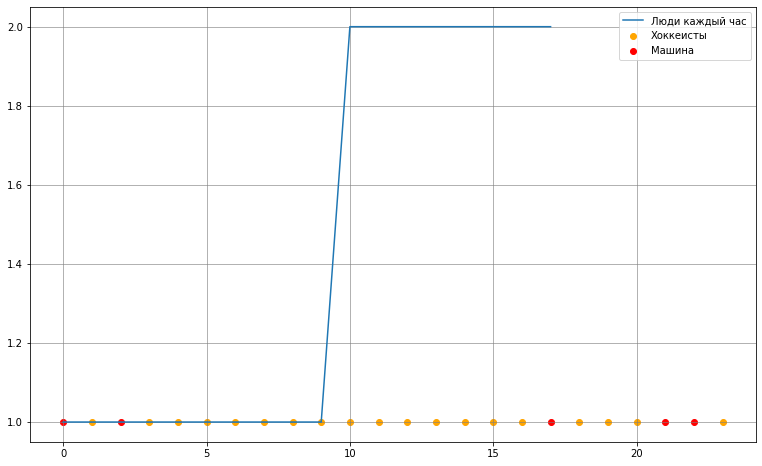

In [20]:
plot(deepcopy(model.gen_dates("201902211330")))

# Время предсказания

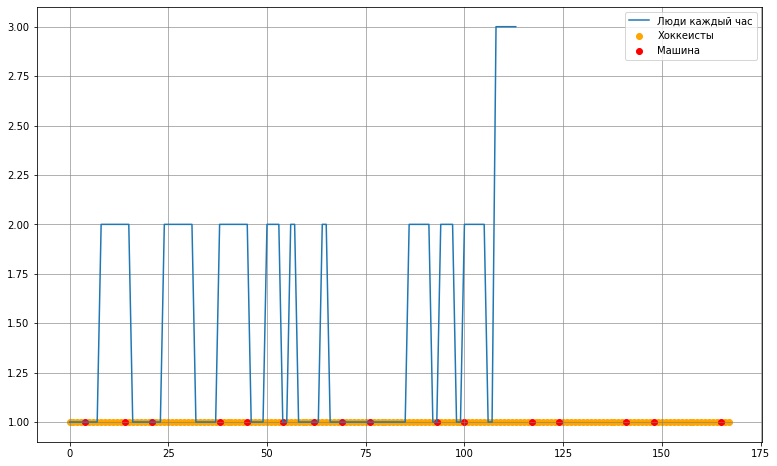

In [21]:
date = "201902110900"
# неделя
plot([model.predict(i) for i in date_to_week(date)])

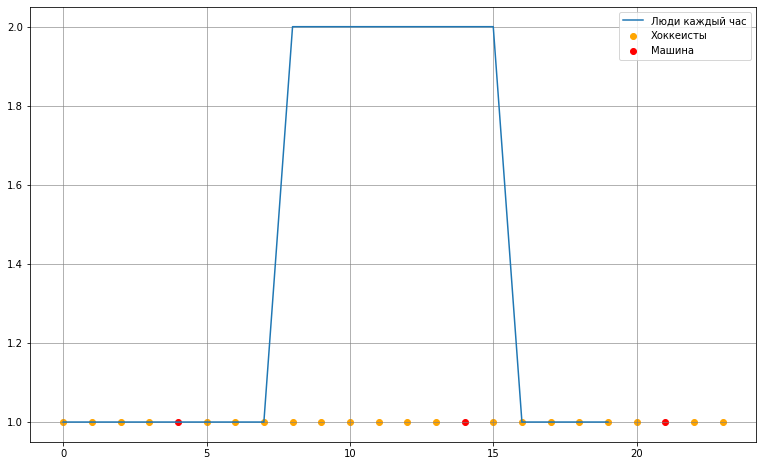

In [22]:
date = "201902110900"
# день
plot([model.predict(i) for i in date_to_range(date)])